In [1]:
using StatsBase
using GLM
using QuantileRegression
using DataFrames
using Gadfly
using Cairo
using Fontconfig
using Formatting
using Compose, Colors


Use "abstract type Solver end" instead.


In [12]:
# get the data into a DataFrame

fulldf = DataFrame()

probnames = [:foo, :galid, :groupid, :cenid, :rband, :Psat, :Mh, :foo2, :foo3, :foo4, :projR, :projrad, :angRh]
corrnames = [:foo5, :galid, :M_r, :M_g, :cz, :Dn4000, :H_delta, :logsSFR, :stelM, :ra, :dec, :vdisp, :S2N, :sersic,
             :conc, :KplusA, :R_exp, :surfdens1kpc, :surfdensR_e, :surfdensR_eo2, :vdisp_err, :Bulge2Tlr, :B2T_err,
             :GMoR_e, :R_e]

probfiles = ["dat/clf_groups_M18_M9.4.prob", "dat/clf_groups_M19_M9.8.prob", "dat/clf_groups_M20_M10.3.prob"]
corrfiles = ["dat/clf_groups_M18_M9.4.galdata_corr", "dat/clf_groups_M19_M9.8.galdata_corr", "dat/clf_groups_M20_M10.2.galdata_corr"]
densfiles = ["dat/density_r10.M18_M9.4", "dat/density_r10.M19_M9.8", "dat/density_r10.M20_M10.3"]
randfiles = ["dat/drandom_r10.M18_M9.4", "dat/drandom_r10.M19_M9.8", "dat/drandom_r10.M20_M10.3"]

for i in 1:3
    
    # read the two catalogues in and join them on galaxy id
    probdf = readtable(probfiles[i], separator=' ', header=false)
    names!(probdf, probnames)
    corrdf = readtable(corrfiles[i], separator=' ', header=false)
    names!(corrdf, corrnames)
    
    # add a column for the density, corrected with the randoms
    density = readdlm(densfiles[i])
    rands = readdlm(randfiles[i])
    ρ_corr = 1.25 * (density[:, 1] ./ rands[:, 1])
    probdf[:ρ_env] = DataArray(ρ_corr)
    
    joindf = join(probdf, corrdf, on=:galid)
   
    if i == 1
        fulldf = joindf
    else
        fulldf = [fulldf; joindf]
    end
end

fulldf = unique(fulldf, :galid)
    

# remove any galaxies in environment density less than or equal to zero, to avoid computational issues
fulldf = fulldf[fulldf[:ρ_env] .> 0.0, :]

# remove bad measurements of R_e, vdisp (i.e. where they are zero)
fulldf = fulldf[fulldf[:R_e] .> 0.0, :]
fulldf = fulldf[fulldf[:vdisp] .> 0.0, :]


# Take only the quenched galaxies
fulldf = fulldf[fulldf[:Dn4000] .> 1.6, :]

# add a column for log10 of stellar mass and log of environment
fulldf[:log10M] = log10.(fulldf[:stelM])
fulldf[:logρ] = log10.(fulldf[:ρ_env])
fulldf[:logρ2] = fulldf[:logρ] .^ 2
fulldf[:logM2] = fulldf[:log10M] .^ 2

# Now take all the rows out which don't have central galaxies
fulldf = fulldf[fulldf[:Psat] .< 0.5, :]

# And a new df for "pure" centrals
puredf = fulldf[fulldf[:Psat] .< 0.01, :]

,foo,galid,groupid,cenid,rband,Psat,Mh,foo2,foo3,foo4,projR,projrad,angRh,ρ_env,foo5,M_r,M_g,cz,Dn4000,H_delta,logsSFR,stelM,ra,dec,vdisp,S2N,sersic,conc,KplusA,R_exp,surfdens1kpc,surfdensR_e,surfdensR_eo2,vdisp_err,Bulge2Tlr,B2T_err,GMoR_e,R_e,log10M,logρ,logρ2,logM2
1,PROB10,17,2485,17,-20.45934,0.0,1.505301e12,0.0,1.505301e12,0.0,0.0,0.0,0.002489693,4.620534098919567,GALDAT_CORR,-20.459339,-19.52249,11982.790039,1.93181,-2.23705,-11.93087,2.32574e10,0.977202,0.007641,224.654999,43.082401,6.0,3.289537,0,4.18451,8.5071e8,2.04648e9,2.46656e9,4.68927,0.71,0.01,107.792,0.002568,10.366561162294122,0.6646921796268715,0.44181569365712126,107.46559033158486
2,PROB10,83,824,83,-20.82109,0.0,4.769398e12,2.052487,4.769398e12,2.052487,0.0,0.0,0.005981735,4.037491605715396,GALDAT_CORR,-20.821091,-19.855761,7303.350098,1.81796,-0.95315,-11.29768,3.41598e10,0.721953,0.015959,195.688004,40.283001,2.68589,3.185269,0,6.62674,3.83006e8,9.00621e8,1.91893e9,4.62724,-999.0,0.0,96.849701,0.004839,10.533515319301785,0.6061116324053456,0.3673713109370728,110.95494498196537
3,PROB10,93,607,93,-21.37808,0.0,6.432387e12,0.0,6.432387e12,0.0,0.0,0.0,0.005765921,3.209461072780544,GALDAT_CORR,-21.37808,-20.40151,8376.849609,1.85702,-1.32328,-12.13293,5.50736e10,0.736818,0.017271,202.039001,42.187801,3.71331,2.855232,0,7.29463,4.53193e8,1.0304e9,2.5889e9,4.49715,-999.0,0.0,118.281998,0.005232,10.740943465968014,0.5064321125396518,0.25647348461137454,115.36786653912098
4,PROB10,99,11864,99,-18.71293,0.0,2.641059e11,0.0,2.641059e11,0.0,0.0,0.0,0.001698125,0.8999116839234984,GALDAT_CORR,-18.712931,-17.87118,9821.610352,1.73772,-0.40409,-11.6214,4.02227e9,0.74412,0.015701,79.491302,28.9055,3.04461,2.688282,0,1.67945,9.26302e8,1.67391e9,8.25183e8,4.07199,0.77,0.07,60.6306,0.000973,9.60447121980981,-0.04580010952366242,0.0020976500323794727,92.24586741215494
5,PROB10,218,1424,218,-20.83903,0.0,2.721754e12,0.0,2.721754e12,0.0,0.0,0.0,0.003302211,4.883816881291285,GALDAT_CORR,-20.839029,-19.84749,10999.320312,1.93528,-2.63873,-12.22909,3.40868e10,0.863652,0.018245,188.425995,33.013401,2.7964,2.796242,0,7.44174,2.08103e8,4.62428e8,8.36261e8,5.50887,0.45,0.0,62.121498,0.003958,10.53258623245291,0.6887593717069869,0.4743894721142033,110.9353727440566
6,PROB10,222,1611,222,-20.31638,0.0,2.39733e12,2.0,2.39733e12,2.0,0.0,0.0,0.003110063,5.020097345572935,GALDAT_CORR,-20.31638,-19.36981,11196.519531,1.88434,-2.14496,-12.04822,2.1236e10,0.869052,0.017126,174.727005,31.5695,6.0,3.009981,0,0.0,3.37969e8,8.7565e8,1.49198e9,5.29266,0.49,0.01,91.769203,0.003496,10.32707271666912,0.7007121387058289,0.49099750132969683,106.64843089537172
7,PROB10,237,12835,237,-18.4337,0.0,2.414243e11,0.0,2.414243e11,0.0,0.0,0.0,0.001629321,1.9192095283615083,GALDAT_CORR,-18.433701,-17.635509,9935.240234,1.80145,3.62374,-10.67433,3.47169e9,0.883338,0.018246,59.784698,11.1745,0.989295,2.479145,0,6.88493,1.19009e8,2.50285e8,3.26235e8,15.2537,0.05,0.02,35.456402,0.003109,9.54054093848024,0.2831223911209624,0.0801582883540512,91.02192139881741
8,PROB10,267,3524,267,-20.21592,0.0,1.026703e12,0.0,1.026703e12,0.0,0.0,0.0,0.002395382,4.00472930438155,GALDAT_CORR,-20.215919,-19.33007,10955.929688,1.84876,-1.70121,-11.75834,1.78245e10,0.928125,0.017808,140.399994,40.9883,4.43531,2.961898,0,3.05284,8.52206e8,1.8651e9,1.742e9,3.72171,0.94,0.0,98.398804,0.002007,10.251017356179636,0.6025731657170086,0.3630944200422175,105.08335683669614
9,PROB10,303,9229,303,-19.19465,0.0,3.50912e11,0.0,3.50912e11,0.0,0.0,0.0,0.001530853,4.587221276310996,GALDAT_CORR,-19.194651,-18.335079,11994.019531,1.83937,0.11096,-11.17117,6.3276e9,0.9833,0.015147,90.880096,23.6038,2.24688,2.755007,0,3.76053,4.0102e8,7.58286e8,7.14623e8,5.86189,0.34,0.02,57.5825,0.001982,9.801239017379089,0.6615496899386126,0.4376479922578745,96.06428627579422
10,PROB10,888,7205,888,-19.43074,0.0,4.636953e11,0.0,4.636953e11,0.0,0.0,0.0,0.002488332,2.348306579396965,GALDAT_CORR,-19.43074,-18.48604,8076.899902,1.95121,-1.92263,-11.71874,8.85471e9,3.681371,

In [13]:
nbins = 5
maxM = maximum(fulldf[:log10M])
minM = minimum(fulldf[:log10M])
Medges = logspace(minM, maxM, nbins + 1)

fullmeans = []
fullmeds = []
puremeans = []
puremeds = []

# set a new column with mean logM for the colours in our plot
fulldf[:meanlogM] = zeros(nrow(fulldf))
for i in 1:nbins
    if i == nbins
        meanM = mean(fulldf[:log10M][log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1])])
        medianM = median(fulldf[:log10M][log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1])])
        fulldf[:meanlogM][log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1])] = meanM
    else    
        meanM = mean(fulldf[:log10M][log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1])])
        medianM = median(fulldf[:log10M][log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1])])
        fulldf[:meanlogM][log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1])] = meanM
    end
    append!(fullmeans, meanM)
    append!(fullmeds, medianM)
end

# same for the pure centrals dataframe
puredf[:meanlogM] = zeros(nrow(puredf))
for i in 1:nbins
    if i == nbins
        meanM = mean(puredf[:log10M][log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1])])
        medianM = median(puredf[:log10M][log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1])])
        puredf[:meanlogM][log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1])] = meanM
    else
        meanM = mean(puredf[:log10M][log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1])])
        medianM = median(puredf[:log10M][log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1])])
        puredf[:meanlogM][log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1])] = meanM
    end
    append!(puremeans, meanM)
    append!(puremeds, medianM)
end

In [14]:
println(fullmeans)
println(fullmeds)
println(puremeans)
println(puremeds)

Any[9.63349, 10.0104, 10.4108, 10.716, 11.063]
Any[9.65451, 10.0179, 10.4096, 10.6943, 11.0413]
Any[9.6349, 10.0119, 10.4122, 10.7173, 11.0638]
Any[9.65649, 10.0202, 10.4115, 10.6956, 11.0422]


In [15]:
# get the density bins to plot in
nrobins = 20
maxfro = maximum(fulldf[:logρ])
minfro = minimum(fulldf[:logρ])
frobins = linspace(minfro, maxfro, nrobins + 1)

fromeans = []
for i in 1:nrobins
    if i == nrobins
        meanro = mean(fulldf[:logρ][frobins[i] .<= fulldf[:logρ] .<= frobins[i + 1]])
    else    
        meanro = mean(fulldf[:logρ][frobins[i] .<= fulldf[:logρ] .< frobins[i + 1]])
    end
    append!(fromeans, meanro)
end

maxpro = maximum(puredf[:logρ])
minpro = minimum(puredf[:logρ])
probins = linspace(minpro, maxpro, nrobins + 1)

promeans = []
for i in 1:nrobins
    if i == nrobins
        meanro = mean(puredf[:logρ][probins[i] .<= puredf[:logρ] .<= probins[i + 1]])
    else    
        meanro = mean(puredf[:logρ][probins[i] .<= puredf[:logρ] .< probins[i + 1]])
    end
    append!(promeans, meanro)
end

In [16]:
function mean_center_logmass(vararr, logmass)
    
    nbins = 20
    maxM = maximum(logmass)
    minM = minimum(logmass)
    Medges = logspace(minM, maxM, nbins + 1)
    
    cenvar = zeros(length(vararr))
    
    for i in 1:nbins
        inds = log10(Medges[i]) .<= logmass .<= log10(Medges[i + 1])
        meanvar = mean(vararr[inds])
        cenvar[inds] = vararr[inds] / meanvar
    end

    return cenvar
end


function get_errbar(binpts)

    npts = length(binpts)
    ymean = mean(binpts)
    ystd = std(binpts)
    yerr = ystd / sqrt(npts)
    
    return ymean, yerr
end

get_errbar (generic function with 1 method)

In [24]:
function linmod(x, y, mod, errminmax)
    
    coeffs = coef(mod)
    fac = [1, sign(x), sign(y), sign(x) * sign(y)]
    
    if errminmax == "max"
        coeffs = coeffs .+ (fac .* stderr(mod))            
    elseif errminmax == "min"
        coeffs = coeffs .- (fac .* stderr(mod))
    end
    
    coeffs[1] + coeffs[2] * x + coeffs[3] * y + coeffs[4] * x * y
end
    
lmfull = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
                Estimate  Std.Error  t value Pr(>|t|)
(Intercept)     0.515981  0.0322113  16.0186   <1e-56
logρ            -0.33607  0.0633692 -5.30336    <1e-6
log10M          0.127633 0.00309397  41.2521   <1e-99
logρ & log10M  0.0345359 0.00608418  5.67635    <1e-7


In [25]:
lmpure = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
                Estimate  Std.Error  t value Pr(>|t|)
(Intercept)     0.504377   0.033866  14.8933   <1e-49
logρ             -0.3847  0.0684457 -5.62051    <1e-7
log10M           0.12872 0.00325137  39.5895   <1e-99
logρ & log10M  0.0391046 0.00656499  5.95654    <1e-8


In [26]:
function linmodsq(x, y, mod, errminmax)

    coeffs = coef(mod)
    fac = [1, sign(x), sign(y), 1, sign(x) * sign(y), sign(y)]
    
    if errminmax == "max"
        coeffs = coeffs .+ (fac .* stderr(mod))
    elseif errminmax == "min"
        coeffs = coeffs .- (fac .* stderr(mod))
    end    
    
    coeffs[1] + coeffs[2] * x + coeffs[3] * y + coeffs[4] * x ^ 2 + coeffs[5] * x * y + coeffs[6] * x ^ 2 * y
end

lmfullsq = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                  Estimate  Std.Error   t value Pr(>|t|)
(Intercept)       0.517061  0.0322361   16.0398   <1e-57
logρ             -0.313055    0.10809  -2.89625   0.0038
log10M            0.127546 0.00309624   41.1939   <1e-99
logρ2           -0.0376256   0.129797 -0.289881   0.7719
logρ & log10M    0.0327056  0.0103831   3.14988   0.0016
log10M & logρ2  0.00296419  0.0124653  0.237795   0.8120


In [27]:
lmpuresq = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                  Estimate  Std.Error   t value Pr(>|t|)
(Intercept)       0.507672  0.0338893   14.9803   <1e-49
logρ             -0.331075   0.112196  -2.95085   0.0032
log10M            0.128436 0.00325316   39.4804   <1e-99
logρ2           -0.0954513   0.139025 -0.686579   0.4924
logρ & log10M    0.0344081  0.0107741   3.19358   0.0014
log10M & logρ2  0.00833469  0.0133402  0.624781   0.5321


In [30]:
function linmodubsq(x, y, mod, errminmax)

    coeffs = coef(mod)
    fac = [1, sign(x), sign(y), 1, 1, sign(x) * sign(y), sign(y), sign(x)]
    
    if errminmax == "max"
        coeffs = coeffs .+ (fac .* stderr(mod))
    elseif errminmax == "min"
        coeffs = coeffs .- (fac .* stderr(mod))
    end    
    
    coeffs[1] + coeffs[2] * x + coeffs[3] * y + coeffs[4] * x ^ 2 + coeffs[5] * y ^ 2 + coeffs[6] * x * y + coeffs[7] * x ^ 2 * y + coeffs[8] * x * y ^ 2
end

lmfulldubsq = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                   Estimate  Std.Error    t value Pr(>|t|)
(Intercept)         5.16607   0.802933      6.434    <1e-9
logρ                1.16852    1.55272   0.752564   0.4517
log10M             -0.77399   0.155576   -4.97499    <1e-6
logρ2            -0.0092248   0.131109 -0.0703596   0.9439
logM2             0.0436748 0.00753379    5.79719    <1e-8
logρ & log10M      -0.24684   0.301016  -0.820021   0.4122
log10M & logρ2  0.000213374  0.0125971  0.0169383   0.9865
logρ & logM2       0.013162  0.0145977   0.901651   0.3672


In [29]:
lmpuredubsq = fit(LinearModel, @formula(Dn4000 ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Dn4000 ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                  Estimate  Std.Error   t value Pr(>|t|)
(Intercept)        5.33462    0.84775   6.29268    <1e-9
logρ              0.910094    1.68787  0.539196   0.5898
log10M           -0.807032   0.164132  -4.91697    <1e-6
logρ2           -0.0520644   0.141414 -0.368171   0.7127
logM2            0.0452914 0.00794201   5.70277    <1e-7
logρ & log10M    -0.197045   0.327092 -0.602414   0.5469
log10M & logρ2  0.00415566  0.0135776  0.306068   0.7596
logρ & logM2     0.0107619  0.0158546  0.678787   0.4973


In [85]:
# Let's start with Dn4000 again

subplots = Array{Gadfly.Plot, 1}(10)

for i in 1:1

    if i == nbins
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1]), :]
    else
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1]), :]
    end

    # first do some mean-centering
    subfull[:cenDn4k] = mean_center_logmass(subfull[:Dn4000], subfull[:log10M])
    subpure[:cenDn4k] = mean_center_logmass(subpure[:Dn4000], subpure[:log10M])
    
    # now get the values for each bin in density
    fDn4kmeans = []
    fDn4kmins = []
    fDn4kmaxs = []
    pDn4kmeans = []
    pDn4kmins = []
    pDn4kmaxs = []
    for j in 1:nrobins
        fDmean, fDerr = get_errbar(subfull[:cenDn4k][frobins[j] .<= subfull[:logρ] .<= frobins[j + 1]])
        pDmean, pDerr = get_errbar(subpure[:cenDn4k][probins[j] .<= subpure[:logρ] .<= probins[j + 1]])
        append!(fDn4kmeans, fDmean)
        append!(fDn4kmins, fDmean - fDerr)
        append!(fDn4kmaxs, fDmean + fDerr)
        append!(pDn4kmeans, pDmean)
        append!(pDn4kmins, pDmean - pDerr)
        append!(pDn4kmaxs, pDmean + pDerr)
    end
    
    fxs = linspace(minimum(subfull[:logρ]), maximum(subfull[:logρ]), 20)
    pxs = linspace(minimum(subpure[:logρ]), maximum(subpure[:logρ]), 20)
    
    fmod(x, err) = linmod(x, fullmeds[i], lmfull, err)    
    
    
    if i == nbins
        subplots[i] = plot(layer(x=fromeans, y=fDn4kmeans, ymin=fDn4kmins, ymax=fDn4kmaxs, Geom.point, Geom.errorbar),
                           layer(
                ),
                           Guide.xlabel("log_10(δ)"), Guide.ylabel("Dn4000 / mean_M(Dn4k)"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.97,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + nbins] = plot(x=promeans, y=pDn4kmeans, ymin=pDn4kmins, ymax=pDn4kmaxs, Geom.point, Geom.errorbar,
                                   Guide.xlabel("log_10(δ)"), Guide.ylabel(nothing),
                                   Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.97,
                                                    Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    else
        subplots[i] = plot(layer(x=fromeans, y=fDn4kmeans, ymin=fDn4kmins, ymax=fDn4kmaxs, Geom.point, Geom.errorbar),
                           layer(x=fxs, color="green",
                                 y=([fmod(x, "") for x in fxs] / mean(subfull[:cenDn4k])),
                                 Geom.line),
                           Guide.xlabel(nothing), Guide.ylabel("Dn4000 / mean_M(Dn4k)"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.97,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + nbins] = plot(x=promeans, y=pDn4kmeans, ymin=pDn4kmins, ymax=pDn4kmaxs, Geom.point, Geom.errorbar,
                                   Guide.xlabel(nothing), Guide.ylabel(nothing),
                                   Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.97,
                                                    Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    end
    
    fxs = linspace(minimum(subfull[:logρ]), maximum(subfull[:logρ]), 20)
    pxs = linspace(minimum(subpure[:logρ]), maximum(subpure[:logρ]), 20)
    
    println(mean(subfull[:cenDn4k]))
    
    fmod(x, err) = linmod(x, fullmeds[i], lmfull, err)
    
    ys = ([fmod(x, "min") for x in fxs] / mean(subfull[:cenDn4k]))
    println(ys)
    ys = ([fmod(x, "") for x in fxs] / mean(subfull[:cenDn4k]))
    println(ys)
    ys = [fmod(x, "max") for x in fxs] / mean(subfull[:cenDn4k])
    println(ys)
    
    flay = layer(x=fxs, color="green",
                 y=([fmod(x, "") for x in fxs] / mean(subfull[:cenDn4k])),
#                  ymin=([fmod(x, "min") for x in fxs] / mean(subfull[:cenDn4k])),
#                  ymax=([fmod(x, "max") for x in fxs] / mean(subfull[:cenDn4k])),
                 Geom.line) # , Geom.ribbon)
    append!(subplots[i].layers, flay)
    
#     fmods(x, err) = linmodsq(x, fullmeds[i], lmfullsq, err)
#     flays = layer(x=xs, color="purple",
#                   y=[fmods(x, "") for x in xs] / mean(subfull[:cenDn4k]),
#                   ymin=[fmods(x, "min") for x in xs] / mean(subfull[:cenDn4k]),
#                   ymax=[fmods(x, "max") for x in xs] / mean(subfull[:cenDn4k]),
#                   Geom.line, Geom.ribbon)
#     append!(subplots[i].layers, flays)
#     
#     pmod(x, err) = linmod(x, puremeds[i], lmpure, err)
#     play = layer(x=xs, color="green",
#                  y=[pmod(x, "") for x in xs] / mean(subpure[:cenDn4k]),
#                  ymin=[pmod(x, "min") for x in xs] / mean(subpure[:cenDn4k]),
#                  ymax=[pmod(x, "max") for x in xs] / mean(subpure[:cenDn4k]),
#                  Geom.line , Geom.ribbon)
#     append!(subplots[i + nbins].layers, play)
#     
#     pmods(x, err) = linmodsq(x, puremeds[i], lmpuresq, err)
#     plays = layer(x=xs, color="purple",
#                   y=[pmods(x, "") for x in xs] / mean(subpure[:cenDn4k]),
#                   ymin=[pmods(x, "min") for x in xs] / mean(subpure[:cenDn4k]),
#                   ymax=[pmods(x, "max") for x in xs] / mean(subpure[:cenDn4k]),
#                   Geom.line , Geom.ribbon)
#     append!(subplots[i + nbins].layers, plays)
    println("this bin done")
end

subplots[1]

# println("stacking...")
# fig = hstack(vstack(subplots[1:5]), vstack(subplots[6:10]))
# println("drawing")
# draw(PNG("errbar_Dn4k_v_rho.png", 6inch, 15inch), fig)
# display("image/png", read("errbar_Dn4k_v_rho.png"))



1.0
[1.60149, 1.6126, 1.62372, 1.63483, 1.64594, 1.65705, 1.66816, 1.67928, 1.68168, 1.67008, 1.65847, 1.64687, 1.63527, 1.62366, 1.61206, 1.60046, 1.58885, 1.57725, 1.56565, 1.55404]
[1.75008, 1.74984, 1.74959, 1.74935, 1.7491, 1.74885, 1.74861, 1.74836, 1.74812, 1.74787, 1.74763, 1.74738, 1.74713, 1.74689, 1.74664, 1.7464, 1.74615, 1.74591, 1.74566, 1.74541]
[1.89867, 1.88707, 1.87547, 1.86386, 1.85226, 1.84066, 1.82905, 1.81745, 1.81455, 1.82566, 1.83678, 1.84789, 1.859, 1.87011, 1.88122, 1.89234, 1.90345, 1.91456, 1.92567, 1.93678]
this bin done


MethodError: [91mMethodError: no method matching evalmapping(::Void, ::String)[0m
Closest candidates are:
  evalmapping([91m::Gadfly.MeltedData[39m, ::AbstractString) at /home/kilian/.julia/v0.6/Gadfly/src/mapping.jl:302
  evalmapping([91m::DataFrames.AbstractDataFrame[39m, ::AbstractString) at /home/kilian/.julia/v0.6/Gadfly/src/mapping.jl:290
  evalmapping(::Any, [91m::AbstractArray[39m) at /home/kilian/.julia/v0.6/Gadfly/src/mapping.jl:285
  ...[39m

In [33]:
lmfull = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
                 Estimate   Std.Error  t value Pr(>|t|)
(Intercept)    -0.0608253   0.0015721 -38.6904   <1e-99
logρ            -0.022101  0.00309279 -7.14596   <1e-12
log10M         0.00636791 0.000151004  42.1705   <1e-99
logρ & log10M  0.00214839 0.000296944    7.235   <1e-12


In [34]:
lmpure = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
                 Estimate   Std.Error  t value Pr(>|t|)
(Intercept)    -0.0613116  0.00164676 -37.2316   <1e-99
logρ           -0.0264226  0.00332823 -7.93894   <1e-14
log10M         0.00641275 0.000158101  40.5612   <1e-99
logρ & log10M  0.00256713 0.000319228  8.04168   <1e-15


In [35]:
lmfullsq = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                   Estimate   Std.Error   t value Pr(>|t|)
(Intercept)      -0.0608222  0.00157336  -38.6576   <1e-99
logρ             -0.0199257  0.00527559  -3.77696   0.0002
log10M           0.00636804  0.00015112   42.1391   <1e-99
logρ2           -0.00330182  0.00633505 -0.521199   0.6022
logρ & log10M    0.00194785 0.000506774   3.84363   0.0001
log10M & logρ2   0.00030273   0.0006084  0.497584   0.6188


In [36]:
lmpuresq = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                   Estimate   Std.Error  t value Pr(>|t|)
(Intercept)      -0.0612568  0.00164798 -37.1709   <1e-99
logρ             -0.0221629  0.00545591 -4.06218    <1e-4
log10M           0.00640797 0.000158196  40.5066   <1e-99
logρ2           -0.00678872  0.00676053 -1.00417   0.3153
logρ & log10M    0.00216302 0.000523929  4.12846    <1e-4
log10M & logρ2   0.00064241  0.00064871 0.990288   0.3220


In [37]:
lmfulldubsq = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                  Estimate   Std.Error   t value Pr(>|t|)
(Intercept)       0.301598   0.0389764   7.73796   <1e-13
logρ              0.593981   0.0753731   7.88054   <1e-14
log10M           -0.063924  0.00755207  -8.46443   <1e-16
logρ2           0.00553134  0.00636438   0.86911   0.3848
logM2           0.00340583  0.00036571   9.31294   <1e-19
logρ & log10M    -0.116326   0.0146121  -7.96092   <1e-14
log10M & logρ2  -0.0005592 0.000611495 -0.914481   0.3605
logρ & logM2    0.00569201  0.00070861   8.03263   <1e-15


In [38]:
lmpuredubsq = fit(LinearModel, @formula(R_e ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: R_e ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                    Estimate   Std.Error   t value Pr(>|t|)
(Intercept)         0.311713   0.0409973   7.60325   <1e-13
logρ                0.640394   0.0816257    7.8455   <1e-14
log10M            -0.0658977  0.00793744  -8.30214   <1e-15
logρ2             0.00646703  0.00683878   0.94564   0.3443
logM2             0.00350186 0.000384077   9.11761   <1e-19
logρ & log10M      -0.125322   0.0158182  -7.92261   <1e-14
log10M & logρ2  -0.000644645 0.000656612 -0.981774   0.3262
logρ & logM2      0.00612762 0.000766732   7.99186   <1e-14


  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31
  likely near /home/kilian/.playground/packages/v0.6/IJulia/src/kernel.jl:31

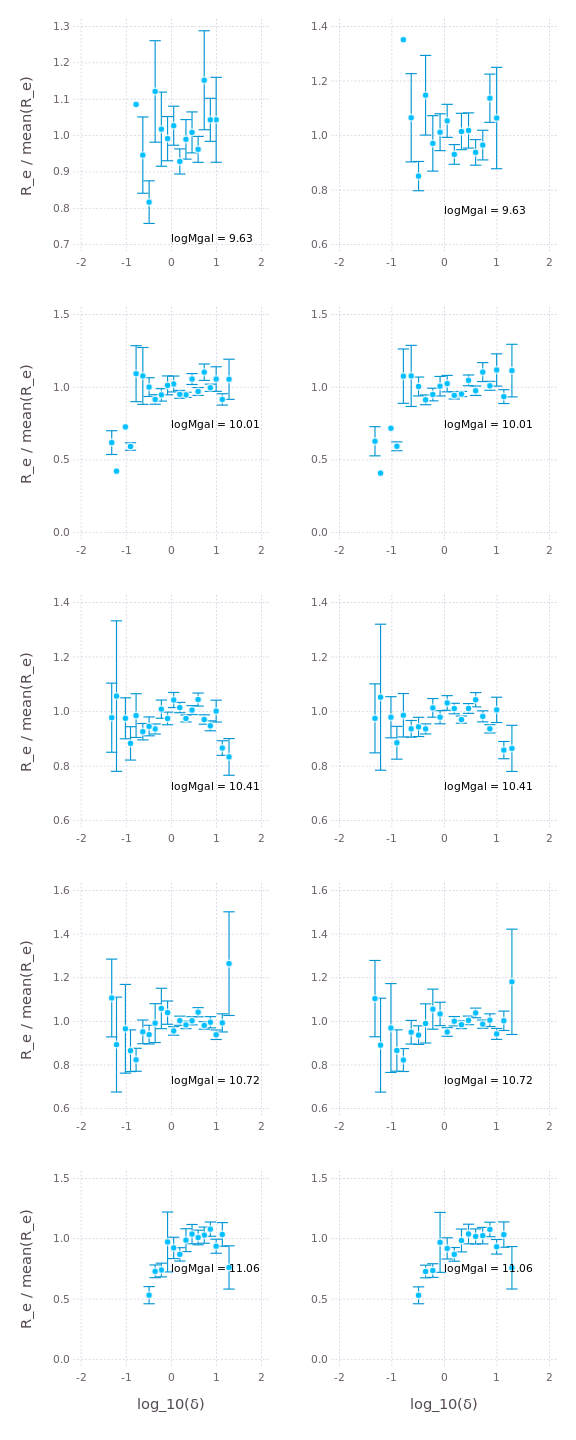

Any[0.53727, NaN, NaN, 0.566726, 0.900389, 0.881932, 0.936201, 0.882782, 0.904355, 0.94767, 0.967361, 0.923448, 0.929689, 1.01862, 0.94355, 1.04689, 0.971144, 0.971457, 0.876928, 0.916399]


In [22]:
# and R_e next

plotargs = 
for i in 1:nbins

    if i == nbins
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1]), :]
    else
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1]), :]
    end

    # first do some mean-centering
    subfull[:cenR_e] = mean_center_logmass(subfull[:R_e], subfull[:log10M])
    subpure[:cenR_e] = mean_center_logmass(subpure[:R_e], subpure[:log10M])
    
    # now get the values for each bin in density
    fmeans = []
    fmins = []
    fmaxs = []
    pmeans = []
    pmins = []
    pmaxs = []
    for j in 1:nrobins
        fmean, ferr = get_errbar(subfull[:cenR_e][frobins[j] .<= subfull[:logρ] .<= frobins[j + 1]])
        pmean, perr = get_errbar(subpure[:cenR_e][probins[j] .<= subpure[:logρ] .<= probins[j + 1]])
        append!(fmeans, fmean)
        append!(fmins, fmean - ferr)
        append!(fmaxs, fmean + ferr)
        append!(pmeans, pmean)
        append!(pmins, pmean - perr)
        append!(pmaxs, pmean + perr)
    end
    
    if i == 2
        println(fmins)
    end
    
    if i == nbins
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,
                           Guide.xlabel("log_10(δ)"), Guide.ylabel("R_e / mean(R_e)"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                   Guide.xlabel("log_10(δ)"), Guide.ylabel(nothing),
                                   Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    else
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,
                           Guide.xlabel(nothing), Guide.ylabel("R_e / mean(R_e)"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                   Guide.xlabel(nothing), Guide.ylabel(nothing),
                                   Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    end
end
    
fig = hstack(vstack(subplots[1:5]), vstack(subplots[6:10]))
draw(PNG("errbar_R_e_v_rho.png", 6inch, 15inch), fig)
display("image/png", read("errbar_R_e_v_rho.png"))


In [39]:
lmfull = fit(LinearModel, @formula(vdisp ~ logρ + log10M + logρ&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: vdisp ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
               Estimate Std.Error  t value Pr(>|t|)
(Intercept)    -974.059   8.02807 -121.332   <1e-99
logρ           -213.498   15.7936  -13.518   <1e-40
log10M          109.226  0.771114  141.647   <1e-99
logρ & log10M   21.0941   1.51637   13.911   <1e-43


In [40]:
lmpure = fit(LinearModel, @formula(vdisp ~ logρ + log10M + logρ&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: vdisp ~ 1 + logρ + log10M + logρ & log10M

Coefficients:
               Estimate Std.Error  t value Pr(>|t|)
(Intercept)    -980.989   8.29172  -118.31   <1e-99
logρ           -233.004   16.7582 -13.9039   <1e-43
log10M          109.879  0.796063  138.029   <1e-99
logρ & log10M   22.9683   1.60737  14.2894   <1e-45


In [41]:
lmfullsq = fit(LinearModel, @formula(vdisp ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: vdisp ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                Estimate Std.Error   t value Pr(>|t|)
(Intercept)     -973.463   8.03342  -121.177   <1e-99
logρ              -209.0   26.9367  -7.75895   <1e-14
log10M           109.177  0.771603   141.494   <1e-99
logρ2           -8.34145   32.3462 -0.257881   0.7965
logρ & log10M    20.8436   2.58754   8.05536   <1e-15
log10M & logρ2  0.491482   3.10644  0.158214   0.8743


In [42]:
lmpuresq = fit(LinearModel, @formula(vdisp ~ logρ + log10M + logρ&log10M + logρ2 + logρ2&log10M), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: vdisp ~ 1 + logρ + log10M + logρ2 + logρ & log10M + logρ2 & log10M

Coefficients:
                Estimate Std.Error   t value Pr(>|t|)
(Intercept)     -979.775   8.29672  -118.092   <1e-99
logρ            -218.536   27.4677   -7.9561   <1e-14
log10M           109.775  0.796433   137.833   <1e-99
logρ2           -27.0001   34.0358 -0.793285   0.4276
logρ & log10M      21.75   2.63771   8.24577   <1e-15
log10M & logρ2   2.27962   3.26592  0.698003   0.4852


In [43]:
lmfulldubsq = fit(LinearModel, @formula(vdisp ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), fulldf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: vdisp ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                Estimate Std.Error   t value Pr(>|t|)
(Intercept)      3834.28   197.186    19.445   <1e-83
logρ             481.268    381.32   1.26211   0.2069
log10M           -823.12   38.2067  -21.5439   <1e-99
logρ2             9.8482   32.1981  0.305863   0.7597
logM2            45.1642   1.85016   24.4109   <1e-99
logρ & log10M   -105.273   73.9241  -1.42407   0.1544
log10M & logρ2  -1.25955   3.09362 -0.407143   0.6839
logρ & logM2     5.72987   3.58493   1.59832   0.1100


In [44]:
lmpuredubsq = fit(LinearModel, @formula(vdisp ~ logρ + log10M + logρ2 + logM2 + logρ&log10M + logρ2&log10M + logM2&logρ), puredf)

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: vdisp ~ 1 + logρ + log10M + logρ2 + logM2 + logρ & log10M + logρ2 & log10M + logM2 & logρ

Coefficients:
                Estimate Std.Error   t value Pr(>|t|)
(Intercept)      3898.75   204.395   19.0746   <1e-80
logρ             763.533   406.951   1.87623   0.0606
log10M          -835.678   39.5727  -21.1175   <1e-97
logρ2            12.0905   34.0953  0.354608   0.7229
logM2            45.7743   1.91484    23.905   <1e-99
logρ & log10M   -159.497   78.8629  -2.02245   0.0431
log10M & logρ2  -1.48064   3.27359 -0.452299   0.6511
logρ & logM2     8.33137    3.8226    2.1795   0.0293


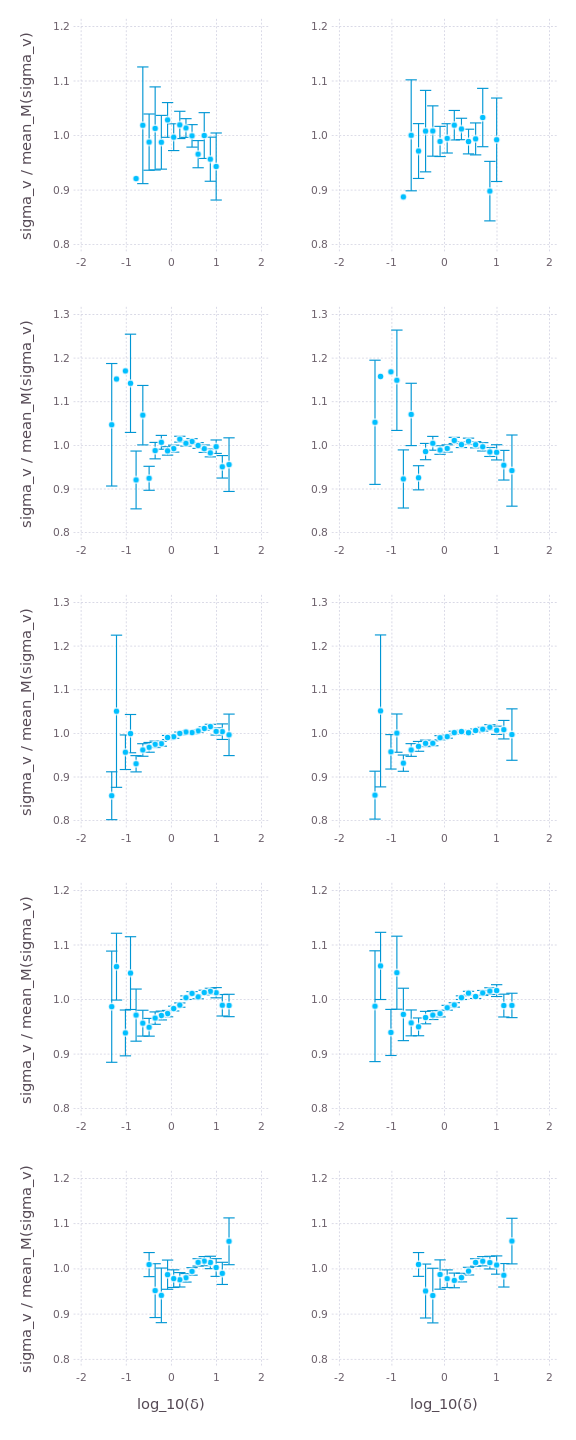

Any[0.906859, NaN, NaN, 1.02964, 0.854527, 1.0011, 0.897093, 0.969144, 0.991168, 0.977633, 0.984506, 1.00746, 0.998394, 1.0024, 0.993124, 0.983819, 0.97365, 0.981532, 0.925144, 0.894404]


In [23]:
# vdisp

for i in 1:nbins

    if i == nbins
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1]), :]
    else
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1]), :]
    end

    # first do some mean-centering
    subfull[:cenv] = mean_center_logmass(subfull[:vdisp], subfull[:log10M])
    subpure[:cenv] = mean_center_logmass(subpure[:vdisp], subpure[:log10M])
    
    # now get the values for each bin in density
    fmeans = []
    fmins = []
    fmaxs = []
    pmeans = []
    pmins = []
    pmaxs = []
    for j in 1:nrobins
        fmean, ferr = get_errbar(subfull[:cenv][frobins[j] .<= subfull[:logρ] .<= frobins[j + 1]])
        pmean, perr = get_errbar(subpure[:cenv][probins[j] .<= subpure[:logρ] .<= probins[j + 1]])
        append!(fmeans, fmean)
        append!(fmins, fmean - ferr)
        append!(fmaxs, fmean + ferr)
        append!(pmeans, pmean)
        append!(pmins, pmean - perr)
        append!(pmaxs, pmean + perr)
    end
    
    if i == 2
        println(fmins)
    end
    
    if i == nbins
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,
                           Guide.xlabel("log_10(δ)"), Guide.ylabel("sigma_v / mean_M(sigma_v)"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                   Guide.xlabel("log_10(δ)"), Guide.ylabel(nothing),
                                   Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    else
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,
                           Guide.xlabel(nothing), Guide.ylabel("sigma_v / mean_M(sigma_v)"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                   Guide.xlabel(nothing), Guide.ylabel(nothing),
                                   Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    end
end
    
fig = hstack(vstack(subplots[1:5]), vstack(subplots[6:10]))
draw(PNG("errbar_sigma_v_rho.png", 6inch, 15inch), fig)
display("image/png", read("errbar_sigma_v_rho.png"))


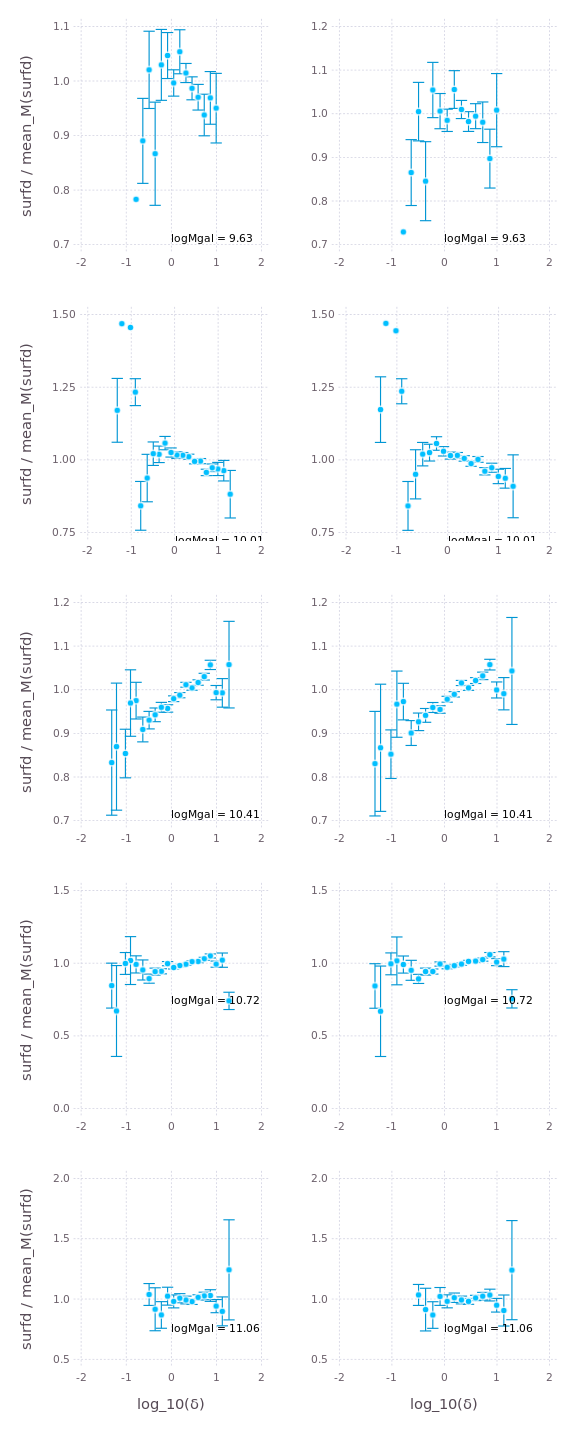

Any[1.06078, NaN, NaN, 1.18671, 0.758289, 0.856081, 0.98103, 0.990859, 1.03479, 1.00981, 1.00506, 1.00653, 1.00208, 0.986403, 0.986987, 0.946008, 0.95989, 0.946206, 0.927698, 0.800444]


In [86]:
# surfdensR_eo2

for i in 1:nbins

    if i == nbins
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1]), :]
    else
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1]), :]
    end

    # first do some mean-centering
    subfull[:censurfd] = mean_center_logmass(subfull[:surfdensR_eo2], subfull[:log10M])
    subpure[:censurfd] = mean_center_logmass(subpure[:surfdensR_eo2], subpure[:log10M])
    
    # now get the values for each bin in density
    fmeans = []
    fmins = []
    fmaxs = []
    pmeans = []
    pmins = []
    pmaxs = []
    for j in 1:nrobins
        fmean, ferr = get_errbar(subfull[:censurfd][frobins[j] .<= subfull[:logρ] .<= frobins[j + 1]])
        pmean, perr = get_errbar(subpure[:censurfd][probins[j] .<= subpure[:logρ] .<= probins[j + 1]])
        append!(fmeans, fmean)
        append!(fmins, fmean - ferr)
        append!(fmaxs, fmean + ferr)
        append!(pmeans, pmean)
        append!(pmins, pmean - perr)
        append!(pmaxs, pmean + perr)
    end
    
    if i == 2
        println(fmins)
    end
    
    if i == nbins
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,
                           Guide.xlabel("log_10(δ)"), Guide.ylabel("surfd / mean_M(surfd)"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                   Guide.xlabel("log_10(δ)"), Guide.ylabel(nothing),
                                   Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    else
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,
                           Guide.xlabel(nothing), Guide.ylabel("surfd / mean_M(surfd)"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                   Guide.xlabel(nothing), Guide.ylabel(nothing),
                                   Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    end
end
    
fig = hstack(vstack(subplots[1:5]), vstack(subplots[6:10]))
draw(PNG("errbar_surfd_v_rho.png", 6inch, 15inch), fig)
display("image/png", read("errbar_surfd_v_rho.png"))


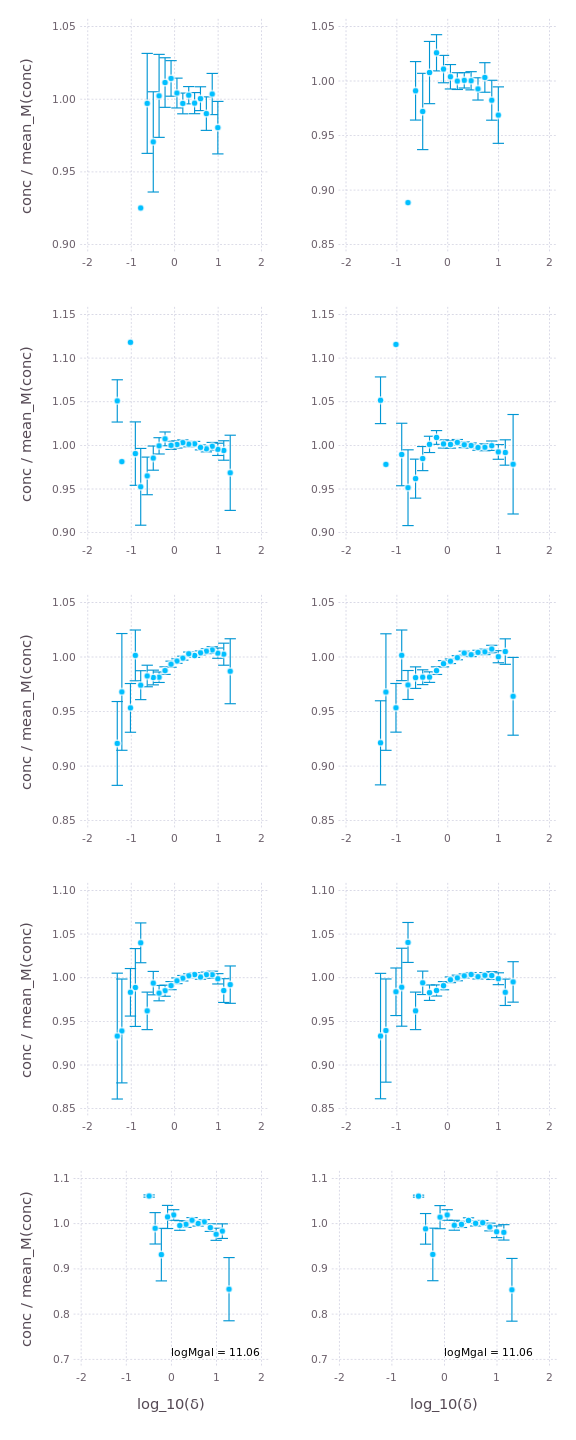

Any[1.02674, NaN, NaN, 0.954225, 0.908532, 0.943454, 0.971564, 0.990122, 0.999596, 0.995372, 0.996959, 0.999958, 0.998363, 0.998986, 0.994812, 0.992561, 0.994546, 0.988435, 0.982999, 0.925495]


In [87]:
# conc

for i in 1:nbins

    if i == nbins
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .<= log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .<= log10(Medges[i + 1]), :]
    else
        subfull = fulldf[log10(Medges[i]) .<= fulldf[:log10M] .< log10(Medges[i + 1]), :]
        subpure = puredf[log10(Medges[i]) .<= puredf[:log10M] .< log10(Medges[i + 1]), :]
    end

    # first do some mean-centering
    subfull[:cenc] = mean_center_logmass(subfull[:conc], subfull[:log10M])
    subpure[:cenc] = mean_center_logmass(subpure[:conc], subpure[:log10M])
    
    # now get the values for each bin in density
    fmeans = []
    fmins = []
    fmaxs = []
    pmeans = []
    pmins = []
    pmaxs = []
    for j in 1:nrobins
        fmean, ferr = get_errbar(subfull[:cenc][frobins[j] .<= subfull[:logρ] .<= frobins[j + 1]])
        pmean, perr = get_errbar(subpure[:cenc][probins[j] .<= subpure[:logρ] .<= probins[j + 1]])
        append!(fmeans, fmean)
        append!(fmins, fmean - ferr)
        append!(fmaxs, fmean + ferr)
        append!(pmeans, pmean)
        append!(pmins, pmean - perr)
        append!(pmaxs, pmean + perr)
    end
    
    if i == 2
        println(fmins)
    end
    
    if i == nbins
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,
                           Guide.xlabel("log_10(δ)"), Guide.ylabel("conc / mean_M(conc)"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                   Guide.xlabel("log_10(δ)"), Guide.ylabel(nothing),
                                   Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    else
        subplots[i] = plot(x=fromeans, y=fmeans, ymin=fmins, ymax=fmaxs, Geom.point, Geom.errorbar,
                           Guide.xlabel(nothing), Guide.ylabel("conc / mean_M(conc)"),
                           Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", fullmeans[i])))))
        
        subplots[i + nbins] = plot(x=promeans, y=pmeans, ymin=pmins, ymax=pmaxs, Geom.point, Geom.errorbar,
                                   Guide.xlabel(nothing), Guide.ylabel(nothing),
                                   Guide.annotation(compose(context(),
                                                    Compose.text(0, 0.7,
                                                    Formatting.format("logMgal = {1:.2f}", puremeans[i])))))
    end
end
    
fig = hstack(vstack(subplots[1:5]), vstack(subplots[6:10]))
draw(PNG("errbar_conc_v_rho.png", 6inch, 15inch), fig)
display("image/png", read("errbar_conc_v_rho.png"))
